In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!nvidia-smi

Fri Mar  1 12:51:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
#Lib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import os
from PIL import Image

In [ ]:
# Define data directories
train_dir = '/content/drive/MyDrive/CT-Kidney/Data-split/train'
valid_dir = '/content/drive/MyDrive/CT-Kidney/Data-split/valid'
test_dir = '/content/drive/MyDrive/CT-Kidney/Data-split/test'

In [ ]:
# Define image dimensions and batch size
image_height = 224
image_width = 224
batch_size = 32

In [16]:
#Agumentation for Train Dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Validation and test data generators (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2400 images belonging to 4 classes.
Found 239 images belonging to 4 classes.
Found 239 images belonging to 4 classes.


In [19]:
# Load pretrained ResNet-101 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

num_classes=4
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout regularization
x = Dense(512, activation='relu')(x)   # Adding another dense layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 [==============================] - 8s 0us/step


In [20]:
num_epochs=10

In [ ]:
# Train the model

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=valid_generator
)

Epoch 1/50
75/75 [==============================] - 1781s 23s/step - loss: 0.7889 - accuracy: 0.7317 - val_loss: 2133.0881 - val_accuracy: 0.2469
Epoch 2/50
75/75 [==============================] - 64s 849ms/step - loss: 0.4233 - accuracy: 0.8525 - val_loss: 15.7322 - val_accuracy: 0.2510
Epoch 3/50
75/75 [==============================] - 65s 862ms/step - loss: 0.2222 - accuracy: 0.9296 - val_loss: 2.6695 - val_accuracy: 0.2510
Epoch 4/50
75/75 [==============================] - 63s 839ms/step - loss: 0.2078 - accuracy: 0.9250 - val_loss: 39.9630 - val_accuracy: 0.2510
Epoch 5/50
75/75 [==============================] - 64s 848ms/step - loss: 0.1539 - accuracy: 0.9513 - val_loss: 26.1201 - val_accuracy: 0.2510
Epoch 6/50
75/75 [==============================] - 64s 855ms/step - loss: 0.1334 - accuracy: 0.9550 - val_loss: 1.6711 - val_accuracy: 0.1883
Epoch 7/50
75/75 [==============================] - 65s 857ms/step - loss: 0.1278 - accuracy: 0.9638 - val_loss: 2.5182 - val_accuracy: 

In [ ]:
#Test the Model with test data
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

8/8 [==============================] - 129s 18s/step - loss: 0.2625 - accuracy: 0.8912
Test Accuracy: 0.8912134170532227


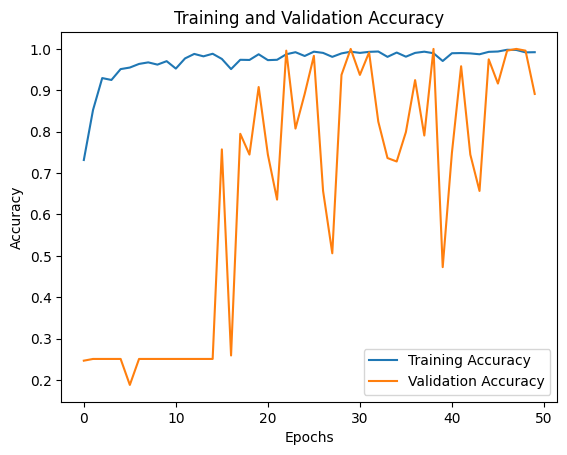

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict classes for test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes

8/8 [==============================] - 4s 229ms/step


In [ ]:
# Generate classification report
print(classification_report(true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.25      0.24      0.25        59
           1       0.26      0.17      0.20        60
           2       0.25      0.27      0.26        60
           3       0.30      0.42      0.35        60

    accuracy                           0.27       239
   macro avg       0.27      0.27      0.26       239
weighted avg       0.27      0.27      0.27       239



In [ ]:
# Save the model
model.save('/content/drive/MyDrive/CT-KIDNEY/ct_kidney_resnet101.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Improvement


In [13]:
# Load the saved model
model = load_model('/content/drive/MyDrive/CT-Kidney/ct_kidney_resnet101.h5')

In [14]:
# Define a new learning rate
new_learning_rate = 0.0001
optimizer = Adam(lr=new_learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [21]:
# Train the model with updated settings

history1 = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=valid_generator,
    callbacks=[reduce_lr]
)

Epoch 1/10
75/75 [==============================] - 1462s 18s/step - loss: 0.7989 - accuracy: 0.7262 - val_loss: 1408.1271 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 64s 845ms/step - loss: 0.3272 - accuracy: 0.8967 - val_loss: 1842.6483 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 63s 837ms/step - loss: 0.1850 - accuracy: 0.9433 - val_loss: 1.6016 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 63s 827ms/step - loss: 0.1891 - accuracy: 0.9400 - val_loss: 13.1272 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - 63s 830ms/step - loss: 0.1777 - accuracy: 0.9450 - val_loss: 5.1254 - val_accuracy: 0.2469 - lr: 0.0010
Epoch 6/10
75/75 [==============================] - 63s 834ms/step - loss: 0.1237 - accuracy: 0.9604 - val_loss: 3.7018 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 7/10
75/75 [==============================] - 64s 8

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 143s 20s/step - loss: 1.9318 - accuracy: 0.2510
Test Loss: 1.9318370819091797
Test Accuracy: 0.2510460317134857


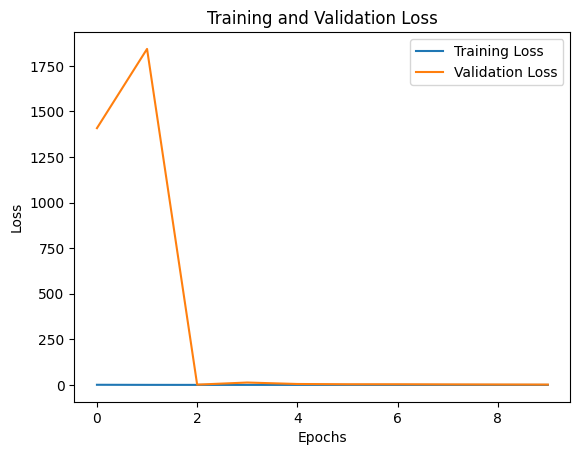

In [23]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

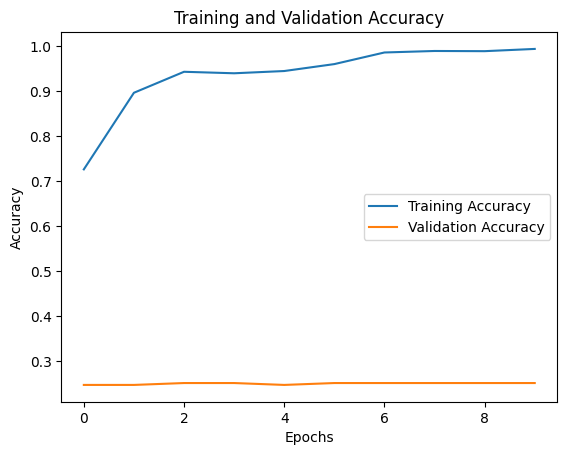

In [24]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [25]:
# Get the true labels and predicted labels for the test dataset
true_classes = test_generator.classes
test_steps = len(test_generator)
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

8/8 [==============================] - 4s 238ms/step


In [28]:
# Save the model
model.save('/content/drive/MyDrive/CT-KIDNEY/ct_kidney_resnet101.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Now, Will check the Model.

In [34]:
# Load the saved model
model = load_model('/content/drive/MyDrive/CT-Kidney/ct_kidney_resnet101.h5')

In [35]:
# Define class labels
class_labels = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Upload image file
uploaded = files.upload()

# Process uploaded images
for filename in uploaded.keys():
    img = Image.open(filename)
    img = img.resize((image_height, image_width))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    # Predict class probabilities
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

Saving Cyst(480).jpg to Cyst(480).jpg
1/1 [==============================] - 2s 2s/step


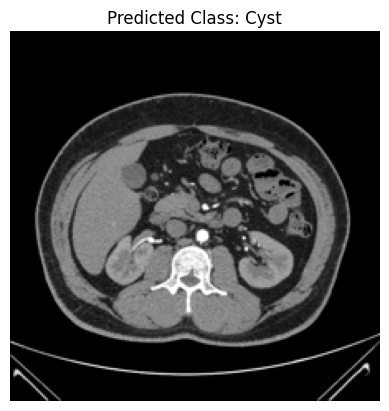

In [36]:
    # Display the image and its predicted class
    plt.imshow(img)
    plt.title('Predicted Class: ' + predicted_class)
    plt.axis('off')
    plt.show()